In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import warnings
import lightgbm as lgb

from collections import Counter
from sklearn import preprocessing
import matplotlib.pyplot as plt 

from sklearn.feature_selection import SelectKBest,chi2,RFE,SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score,roc_curve, plot_roc_curve
from contextlib import contextmanager

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

plt.rc("font", size=14)
warnings.simplefilter(action='ignore')


path = 'C:/data/'

def reduce_mem_usage(data):
    start_mem = data.memory_usage().sum() / 1024**2
    
    print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2

    print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data

In [2]:
data_app = pd.read_csv("C:/data/processing_data/data_app.csv")
data_app = reduce_mem_usage(data_app)
data_app.head(10)

Memory usage of dataframe: 520.84 MB
Memory usage after optimization: 130.50 MB
Decreased by 74.9%


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,-0.324463,-0.717773,0.664551,-0.577637,0.142090,-0.478027,-0.166016,-0.505859,-0.149658,...,-0.086731,-0.076294,-0.072876,-0.522949,1.934570,-0.133179,-0.949219,0.963867,-0.087341,1
1,100003,-0.324463,-0.717773,-1.504883,-0.577637,0.426758,1.725586,0.592773,1.600586,-1.252930,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,-0.949219,0.963867,-0.087341,0
2,100004,3.082031,1.392578,0.664551,-0.577637,-0.427246,-1.153320,-1.404297,-1.089844,-0.783203,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
3,100006,-0.324463,-0.717773,0.664551,-0.577637,-0.142578,-0.711426,0.177979,-0.651855,-0.929199,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
4,100007,-0.324463,-0.717773,0.664551,-0.577637,-0.199463,-0.213745,-0.361572,-0.067383,0.562988,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
5,100008,-0.324463,-0.717773,0.664551,-0.577637,-0.294434,-0.269531,0.028290,-0.225708,1.079102,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
6,100009,-0.324463,1.392578,0.664551,0.807129,0.009285,2.388672,0.979004,2.318359,1.079102,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
7,100010,-0.324463,1.392578,0.664551,-0.577637,0.806152,2.312500,1.032227,2.683594,-1.283203,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
8,100011,-0.324463,-0.717773,0.664551,-0.577637,-0.237427,1.044922,0.463623,1.016602,-0.161865,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0
9,100012,3.082031,-0.717773,0.664551,-0.577637,-0.142578,-0.482178,-0.473145,-0.359619,-0.085693,...,-0.086731,-0.076294,-0.072876,-0.522949,-0.516602,-0.133179,1.053711,-1.038086,-0.087341,0


In [3]:
data_app.shape

(307511, 222)

# bureau

In [4]:
bureau = pd.read_csv("C:/data/processing_data/bureau.csv")
bureau = reduce_mem_usage(bureau)

Memory usage of dataframe: 170.32 MB
Memory usage after optimization: 60.08 MB
Decreased by 64.7%


In [5]:
bureau.head(10)

,SK_ID_CURR,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,...,NEW_RATIO_BURO_DAYS_CREDIT_MAX,NEW_RATIO_BURO_DAYS_CREDIT_MEAN,NEW_RATIO_BURO_DAYS_CREDIT_VAR,NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN,NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX,NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MEAN,NEW_RATIO_BURO_DAYS_CREDIT_UPDATE_MEAN,NEW_RATIO_BURO_AMT_CREDIT_SUM_MAX,NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN,NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM
0,100001,-1572,-49,-735.000,2.400437e+05,-1329.0,1778.0,82.4375,-93.12500,0.000000,...,0.057190,0.293457,0.544427,-0.309326,-9.929688,-1.638672,0.068848,1.351351,2.070292,1.552719
1,100002,-1437,-103,-874.000,1.861500e+05,-1072.0,780.0,-349.0000,-500.00000,1681.029053,...,0.216431,0.587402,3.556569,-0.727539,9.179688,-1.356445,0.023438,3.333333,3.774707,1.258236
2,100003,-2586,-606,-1401.000,8.277836e+05,-2434.0,1216.0,-544.5000,-816.00000,0.000000,...,0.781738,0.363770,0.000000,-0.499512,-2.894531,-1.075195,0.040039,7.200000,11.716461,3.905487
3,100004,-1326,-408,-867.000,4.213620e+05,-595.0,-382.0,-488.5000,-532.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,100005,-373,-62,-190.625,2.634033e+04,-128.0,1324.0,439.2500,-54.34375,0.000000,...,0.166260,0.266846,0.000000,-0.953125,-10.343750,-5.648438,0.173584,9.723077,5.116462,10.232924
5,100007,-1149,-1149,-1149.000,0.000000e+00,-783.0,-783.0,-783.0000,-783.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,100008,-1097,-78,-757.500,3.461203e+05,-853.0,471.0,-391.2500,-611.00000,0.000000,...,0.071106,0.071106,0.000000,-0.552246,-0.594727,-0.572754,0.017609,2.531631,2.664874,1.332437
7,100009,-2882,-239,-1272.000,4.426300e+05,-2152.0,1402.0,-795.0000,-851.50000,0.000000,...,0.349365,0.403809,0.656090,0.097107,1.342773,-0.600586,0.239868,0.361666,1.633381,0.466680
8,100010,-2741,-1138,-1940.000,1.284804e+06,-928.0,689.0,-119.5000,-578.00000,0.000000,...,0.415283,0.415283,0.000000,-0.742676,-0.742676,-0.742676,0.015823,2.142857,2.142857,2.142857
9,100011,-2508,-1309,-1773.000,3.334180e+05,-2172.0,-860.0,-1293.0000,-1455.00000,5073.615234,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
bureau.shape

(305811, 73)

In [7]:
data_app.shape

(307511, 222)

In [8]:
all_data = pd.merge(data_app,bureau,on='SK_ID_CURR', how ="left")
del bureau
gc.collect()
all_data.shape

(307511, 294)

# credit

In [9]:
credit = pd.read_csv("C:/data/processing_data/credit.csv")
credit = reduce_mem_usage(credit)
credit.shape

Memory usage of dataframe: 83.75 MB
Memory usage after optimization: 32.49 MB
Decreased by 61.2%


(103558, 106)

In [10]:
credit.head(10)

,SK_ID_CURR,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,...,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100006,-6,-1,-3.5,-21,3.500,0.0,0.000000,0.000000,0.000000e+00,...,1,1.000000,6,0.000000,0,0.000000,0,0.000000,0.000000,6
1,100011,-75,-2,-38.5,-2849,462.500,0.0,189000.000000,54482.109375,4.031676e+06,...,1,1.000000,74,0.000000,0,0.000000,0,0.000000,0.000000,74
2,100013,-96,-1,-48.5,-4656,776.000,0.0,161420.218750,18159.919922,1.743352e+06,...,1,1.000000,96,0.000000,0,0.000000,0,0.000000,0.000000,96
3,100021,-18,-2,-10.0,-170,25.500,0.0,0.000000,0.000000,0.000000e+00,...,0,0.411865,7,0.257324,1,0.588379,10,0.257324,0.000000,17
4,100023,-11,-4,-7.5,-60,6.000,0.0,0.000000,0.000000,0.000000e+00,...,1,1.000000,8,0.000000,0,0.000000,0,0.000000,0.000000,8
5,100028,-49,-1,-25.0,-1225,204.125,0.0,37335.914062,8085.058105,3.961678e+05,...,1,1.000000,49,0.000000,0,0.000000,0,0.000000,0.000000,49
6,100036,-13,-2,-7.5,-90,13.000,0.0,0.000000,0.000000,0.000000e+00,...,1,1.000000,12,0.000000,0,0.000000,0,0.000000,0.000000,12
7,100042,-84,-1,-42.5,-3570,595.000,0.0,93118.453125,33356.183594,2.801920e+06,...,1,1.000000,84,0.000000,0,0.000000,0,0.000000,0.000000,84
8,100043,-33,-1,-17.0,-561,93.500,0.0,435861.593750,208572.593750,6.882896e+06,...,1,1.000000,33,0.000000,0,0.000000,0,0.000000,0.000000,33
9,100047,-39,-4,-21.5,-774,111.000,0.0,0.000000,0.000000,0.000000e+00,...,0,0.972168,35,0.027771,0,0.000000,0,0.000000,0.027771,36


In [11]:
all_data = pd.merge(all_data,credit,on='SK_ID_CURR', how ="left")
del credit
gc.collect()
all_data.shape

(307511, 399)

# ins

In [12]:
ins = pd.read_csv("C:/data/processing_data/ins.csv")
ins = reduce_mem_usage(ins)
ins.shape

Memory usage of dataframe: 69.95 MB
Memory usage after optimization: 29.47 MB
Decreased by 57.9%


(339587, 27)

In [13]:
ins.head(10)

,SK_ID_CURR,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100001,2,11.0,1.571289,11.0,36.0,8.859375,62.0,1.0,1.000000,...,5885.132324,4.119593e+04,3951.000000,17397.900391,5885.132324,4.119593e+04,-1628.0,-2196.0,-15365.0,7
1,100002,2,0.0,0.000000,0.0,31.0,20.421875,388.0,1.0,1.000000,...,11559.247070,2.196257e+05,9251.775391,53093.746094,11559.247070,2.196257e+05,-49.0,-315.5,-5993.0,19
2,100003,2,0.0,0.000000,0.0,14.0,7.160156,179.0,1.0,1.000000,...,64754.585938,1.618865e+06,6662.970215,560835.375000,64754.585938,1.618865e+06,-544.0,-1385.0,-34633.0,25
3,100004,2,0.0,0.000000,0.0,11.0,7.667969,23.0,1.0,1.000000,...,7096.154785,2.128846e+04,5357.250000,10573.964844,7096.154785,2.128846e+04,-727.0,-761.5,-2285.0,3
4,100005,2,1.0,0.111084,1.0,37.0,23.671875,213.0,1.0,1.000000,...,6240.205078,5.616184e+04,4813.200195,17656.244141,6240.205078,5.616184e+04,-470.0,-609.5,-5486.0,9
5,100006,2,0.0,0.000000,0.0,77.0,19.375000,310.0,1.0,1.000000,...,62947.089844,1.007153e+06,2482.919922,691786.875000,62947.089844,1.007153e+06,-12.0,-271.5,-4346.0,16
6,100007,2,12.0,0.954590,63.0,31.0,4.589844,303.0,1.0,0.954590,...,12666.444336,8.359853e+05,0.180000,22678.785156,12214.060547,8.061280e+05,-14.0,-1032.0,-68128.0,66
7,100008,2,1317.0,37.625000,1317.0,28.0,11.515625,403.0,1.0,0.971191,...,27702.964844,9.696038e+05,227.160004,432218.281250,27360.501953,9.576176e+05,-82.0,-1238.0,-43323.0,35
8,100009,1,7.0,0.137207,7.0,23.0,8.726562,445.0,1.0,1.000000,...,9568.532227,4.879951e+05,6155.279785,17341.605469,9568.532227,4.879951e+05,-58.0,-864.5,-44085.0,51
9,100010,1,0.0,0.000000,0.0,30.0,11.898438,119.0,1.0,1.000000,...,27449.207031,2.744921e+05,27321.390625,27463.410156,27449.207031,2.744921e+05,-774.0,-916.0,-9159.0,10


In [14]:
all_data = pd.merge(all_data,ins,on='SK_ID_CURR', how ="left")
del ins
gc.collect()
all_data.shape

(307511, 425)

# pos

In [15]:
pos = pd.read_csv("C:/data/processing_data/pos.csv")
pos = reduce_mem_usage(pos)
pos.shape

Memory usage of dataframe: 30.88 MB
Memory usage after optimization: 8.04 MB
Decreased by 74.0%


(337252, 12)

In [16]:
pos.head(10)

,SK_ID_CURR,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_COUNT
0,100001,-53,-72.562500,9,7,0.777832,7,0.777832,0.777832,0.222168,0.000000,9
1,100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.000000,0.000000,19
2,100003,-18,-43.781250,28,0,0.000000,0,0.000000,0.928711,0.071411,0.000000,28
3,100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.250000,0.000000,4
4,100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818359,0.090881,0.090881,11
5,100006,-1,-9.617188,21,0,0.000000,0,0.000000,0.856934,0.095215,0.000000,21
6,100007,-1,-33.625000,66,0,0.000000,0,0.000000,0.939453,0.045441,0.015152,66
7,100008,-2,-43.656250,83,1294,339.000000,0,0.000000,0.939941,0.048187,0.012047,83
8,100009,-1,-33.062500,64,0,0.000000,0,0.000000,0.890625,0.109375,0.000000,64
9,100010,-25,-30.000000,11,0,0.000000,0,0.000000,0.909180,0.090881,0.000000,11


In [17]:
all_data = pd.merge(all_data,pos,on='SK_ID_CURR', how ="left")
del pos
gc.collect()
all_data.shape

(307511, 436)

# prev

In [18]:
prev = pd.read_csv("C:/data/processing_data/prev.csv")
prev = reduce_mem_usage(prev)
prev.shape

Memory usage of dataframe: 361.94 MB
Memory usage after optimization: 111.81 MB
Decreased by 69.1%


(338857, 140)

In [19]:
prev.head(10)

,SK_ID_CURR,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,...,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM
0,100001,3951.000000,3951.000000,3951.000000,24835.5,24835.5,24835.500000,23787.0,23787.0,23787.000000,...,13.0,13.000000,0.104309,0.104309,0.104309,-1740.0,-1740.0,-1740.0,8.000000,8.0
1,100002,9251.775391,9251.775391,9251.775391,179055.0,179055.0,179055.000000,179055.0,179055.0,179055.000000,...,9.0,9.000000,0.000000,0.000000,0.000000,-606.0,-606.0,-606.0,24.000000,24.0
2,100003,6737.310059,98356.992188,56553.988281,68809.5,900000.0,435436.500000,68053.5,1035882.0,484191.000000,...,17.0,14.664062,0.000000,0.100037,0.050018,-2340.0,-746.0,-1305.0,10.000000,30.0
3,100004,5357.250000,5357.250000,5357.250000,24282.0,24282.0,24282.000000,20106.0,20106.0,20106.000000,...,5.0,5.000000,0.212036,0.212036,0.212036,-815.0,-815.0,-815.0,4.000000,4.0
4,100005,4813.200195,4813.200195,4813.200195,0.0,44617.5,22308.750000,0.0,40153.5,20076.750000,...,11.0,11.000000,0.108948,0.108948,0.108948,-757.0,-757.0,-757.0,12.000000,12.0
5,100006,2482.919922,39954.511719,23651.175781,0.0,688500.0,272203.250000,0.0,906615.0,291695.500000,...,15.0,14.398438,0.109009,0.217773,0.163452,-617.0,-181.0,-345.5,18.000000,90.0
6,100007,1834.290039,22678.785156,12278.804688,17176.5,247500.0,150530.250000,14616.0,284400.0,166638.750000,...,15.0,12.335938,0.100159,0.218872,0.159546,-2356.0,-374.0,-1223.0,20.671875,124.0
7,100008,8019.089844,25309.574219,15839.696289,0.0,450000.0,155701.796875,0.0,501975.0,162767.703125,...,13.0,10.500000,0.000000,0.110229,0.073059,-2536.0,-370.0,-1470.0,14.000000,56.0
8,100009,7435.845215,17341.605469,10051.412109,40455.0,110160.0,76741.710938,38574.0,98239.5,70137.640625,...,18.0,13.710938,0.000000,0.209473,0.126587,-1562.0,-74.0,-719.5,8.000000,56.0
9,100010,27463.410156,27463.410156,27463.410156,247212.0,247212.0,247212.000000,260811.0,260811.0,260811.000000,...,16.0,16.000000,0.000000,0.000000,0.000000,-1070.0,-1070.0,-1070.0,10.000000,10.0


In [20]:
all_data = pd.merge(all_data,prev,on='SK_ID_CURR', how ="left")
del prev
gc.collect()
all_data.shape

(307511, 575)

# LSTM_feature

In [21]:
lstm = pd.read_csv("C:/data/processing_data/LSTM_Feature.csv")
lstm = reduce_mem_usage(lstm)
lstm.shape

Memory usage of dataframe: 77.42 MB
Memory usage after optimization: 19.94 MB
Decreased by 74.2%


(307511, 33)

In [22]:
lstm.head(10)

,SK_ID_CURR,LSTM_1,LSTM_2,LSTM_3,LSTM_4,LSTM_5,LSTM_6,LSTM_7,LSTM_8,LSTM_9,...,LSTM_23,LSTM_24,LSTM_25,LSTM_26,LSTM_27,LSTM_28,LSTM_29,LSTM_30,LSTM_31,LSTM_32
0,100002,0.0,0.0,0.047943,0.675781,0.0,0.0,0.0,0.039154,0.0,...,0.262939,0.0,0.162842,0.139404,0.488281,0.0,0.0,0.624512,0.304199,0.323242
1,100003,0.0,0.0,0.243164,2.429688,0.0,0.0,0.0,0.916504,0.0,...,0.622070,0.0,0.825195,0.000000,1.728516,0.0,0.0,2.693359,1.545898,1.300781
2,100004,0.0,0.0,0.209839,1.746094,0.0,0.0,0.0,0.819824,0.0,...,0.556152,0.0,0.493408,0.729492,1.445312,0.0,0.0,2.021484,0.999512,0.889160
3,100006,0.0,0.0,0.185913,1.388672,0.0,0.0,0.0,0.582520,0.0,...,0.650391,0.0,0.457764,0.000000,1.086914,0.0,0.0,1.581055,0.726074,0.801758
4,100007,0.0,0.0,0.283447,1.401367,0.0,0.0,0.0,0.648438,0.0,...,0.322754,0.0,0.527832,0.000000,1.129883,0.0,0.0,1.547852,0.803223,0.759277
5,100008,0.0,0.0,0.257324,1.518555,0.0,0.0,0.0,0.591309,0.0,...,0.354248,0.0,0.462158,0.621094,1.134766,0.0,0.0,1.626953,0.891602,0.897949
6,100009,0.0,0.0,0.183472,2.175781,0.0,0.0,0.0,0.404785,0.0,...,0.724121,0.0,0.611816,0.491943,1.828125,0.0,0.0,1.815430,1.048828,1.099609
7,100010,0.0,0.0,0.272705,1.950195,0.0,0.0,0.0,0.732910,0.0,...,0.714355,0.0,0.713867,0.540527,1.346680,0.0,0.0,2.126953,1.164062,1.132812
8,100011,0.0,0.0,0.201294,1.373047,0.0,0.0,0.0,0.608398,0.0,...,0.205688,0.0,0.506836,0.751953,1.060547,0.0,0.0,1.671875,0.832520,0.958496
9,100012,0.0,0.0,0.225342,1.538086,0.0,0.0,0.0,0.650879,0.0,...,0.746582,0.0,0.452881,0.000000,1.239258,0.0,0.0,1.718750,0.853027,0.817383


In [23]:
all_data = pd.merge(all_data,lstm,on='SK_ID_CURR', how ="left")
del lstm
gc.collect()
all_data.shape

(307511, 607)

In [24]:
# 删除缺失值较多的特征
def missing_values(df):
        # 缺失的总个数
        mis_val = df.isnull().sum()
        
        # 计算百分比
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # 合并
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # 重命名
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Count', 1 : 'percent'})
        
        # 根据缺失值降序排列
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('percent', ascending=False).round(1)
        
        # Print some summary information
        print ("selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [25]:
missing_values(all_data).head(30)

selected dataframe has 607 columns.
There are 353 columns that have missing values.


,Missing Count,percent
CC_AMT_PAYMENT_CURRENT_VAR,246892,80.3
CC_CNT_DRAWINGS_POS_CURRENT_VAR,246818,80.3
CC_AMT_DRAWINGS_POS_CURRENT_VAR,246818,80.3
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,246818,80.3
CC_AMT_DRAWINGS_ATM_CURRENT_VAR,246818,80.3
CC_CNT_DRAWINGS_ATM_CURRENT_VAR,246818,80.3
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,246818,80.3
CC_AMT_PAYMENT_CURRENT_MEAN,246451,80.1
CC_AMT_PAYMENT_CURRENT_MAX,246451,80.1
CC_AMT_PAYMENT_CURRENT_MIN,246451,80.1


In [26]:
def drop_columns(df,percent):
    # 删除超过百分比的列
    # 还要加上table, percent参数
    table = missing_values(df)
    drop_list = table.loc[table["percent"] > percent,:].index.tolist()
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [27]:
drop_columns(all_data, 80)

selected dataframe has 607 columns.
There are 353 columns that have missing values.


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,LSTM_23,LSTM_24,LSTM_25,LSTM_26,LSTM_27,LSTM_28,LSTM_29,LSTM_30,LSTM_31,LSTM_32
0,100002,-0.324463,-0.717773,0.664551,-0.577637,0.142090,-0.478027,-0.166016,-0.505859,-0.149658,...,0.262939,0.0,0.162842,0.139404,0.488281,0.0,0.0,0.624512,0.304199,0.323242
1,100003,-0.324463,-0.717773,-1.504883,-0.577637,0.426758,1.725586,0.592773,1.600586,-1.252930,...,0.622070,0.0,0.825195,0.000000,1.728516,0.0,0.0,2.693359,1.545898,1.300781
2,100004,3.082031,1.392578,0.664551,-0.577637,-0.427246,-1.153320,-1.404297,-1.089844,-0.783203,...,0.556152,0.0,0.493408,0.729492,1.445312,0.0,0.0,2.021484,0.999512,0.889160
3,100006,-0.324463,-0.717773,0.664551,-0.577637,-0.142578,-0.711426,0.177979,-0.651855,-0.929199,...,0.650391,0.0,0.457764,0.000000,1.086914,0.0,0.0,1.581055,0.726074,0.801758
4,100007,-0.324463,-0.717773,0.664551,-0.577637,-0.199463,-0.213745,-0.361572,-0.067383,0.562988,...,0.322754,0.0,0.527832,0.000000,1.129883,0.0,0.0,1.547852,0.803223,0.759277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,-0.324463,-0.717773,-1.504883,-0.577637,-0.047638,-0.855469,0.031082,-0.846680,0.845215,...,0.681641,0.0,0.379883,0.000000,1.107422,0.0,0.0,1.379883,0.635742,0.679688
307507,456252,-0.324463,-0.717773,0.664551,-0.577637,-0.408203,-0.818359,-1.041992,-0.846680,0.310303,...,0.115967,0.0,0.510742,0.000000,1.006836,0.0,0.0,1.624023,0.885254,1.083008
307508,456253,-0.324463,-0.717773,0.664551,-0.577637,-0.066650,0.195435,0.198120,0.127441,-1.147461,...,0.535645,0.0,0.757812,0.218872,1.798828,0.0,0.0,2.322266,1.127930,0.837402
307509,456254,-0.324463,-0.717773,0.664551,-0.577637,0.009285,-0.568848,-0.476318,-0.590820,-1.124023,...,0.514160,0.0,0.268555,0.661133,0.613281,0.0,0.0,0.959473,0.445312,0.591797


In [28]:
all_data.shape

(307511, 579)

In [29]:
drop_list_bureau = []
for col in all_data.columns:
    print("\n %s 属性的不同取值和出现的次数" %col)
    print(all_data[col].value_counts())
    if all_data[col].value_counts().max() > 290520:  # 290520/307511 = 0.95
        drop_list_bureau.append(col)


 SK_ID_CURR 属性的不同取值和出现的次数
100002    1
337664    1
337661    1
337660    1
337659    1
         ..
218992    1
218991    1
218990    1
218989    1
456255    1
Name: SK_ID_CURR, Length: 307511, dtype: int64

 NAME_CONTRACT_TYPE 属性的不同取值和出现的次数
-0.324463    278232
 3.082031     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

 FLAG_OWN_CAR 属性的不同取值和出现的次数
-0.717773    202924
 1.392578    104587
Name: FLAG_OWN_CAR, dtype: int64

 FLAG_OWN_REALTY 属性的不同取值和出现的次数
 0.664551    213312
-1.504883     94199
Name: FLAG_OWN_REALTY, dtype: int64

 CNT_CHILDREN 属性的不同取值和出现的次数
-0.577637     215371
 0.807129      61119
 2.191406      26749
 3.576172       3717
 4.960938        429
 6.347656         84
 7.730469         21
 9.117188          7
 18.812500         3
 10.500000         2
 11.882812         2
 16.046875         2
 13.273438         2
 25.734375         2
 14.656250         1
Name: CNT_CHILDREN, dtype: int64

 AMT_INCOME_TOTAL 属性的不同取值和出现的次数
-0.142578    35752
-0.237427    31020
-0.047638    26556
 0.


 ENTRANCES_MEDI 属性的不同取值和出现的次数
-0.720703    155157
 0.621094     35535
-0.049774     24193
 0.285156     20492
 1.291992     19750
-0.385254     16150
 0.956055      9566
 1.962891      8048
 1.627930      4318
 2.632812      2108
 2.296875      2086
 0.117676      1352
 0.453613      1228
 3.304688      1198
 2.970703      1010
 0.788574       788
-0.217773       611
 1.125000       554
 3.976562       503
 3.638672       438
 4.644531       352
 4.308594       304
 1.458984       278
 5.316406       241
 4.984375       187
 1.793945       169
 9.007812       153
 5.992188       116
 2.130859       106
 5.652344        68
 2.466797        59
 8.000000        52
 6.660156        48
 6.324219        44
 7.328125        42
 2.800781        39
 6.992188        39
 3.470703        31
 8.671875        25
 8.335938        21
 3.136719        14
 7.667969        14
 3.808594        12
-0.553223         7
 4.812500         4
 4.144531         1
Name: ENTRANCES_MEDI, dtype: int64

 FLOORSMAX_ME

 0.601562    117628
-1.528320     55374
-0.582031     43670
 0.128174     38412
 1.785156     17570
-1.055664      9334
-0.108459      9138
 0.364990      3247
 2.968750      3030
-0.464600      2704
 2.257812      2341
-1.765625      2157
 0.838379      1972
 1.027344       429
 4.152344       305
-0.368896       112
 1.607422        64
 0.861816        24
Name: NEW_INC_BY_ORG, dtype: int64

 NEW_PHONE_TO_BIRTH_RATIO 属性的不同取值和出现的次数
-1.128906    37673
-1.126953     2398
-1.127930     1914
-1.125977     1507
-1.125000     1149
             ...  
 3.775391        1
 0.028656        1
-0.010490        1
 0.006905        1
 0.009834        1
Name: NEW_PHONE_TO_BIRTH_RATIO, Length: 16299, dtype: int64

 NEW_PHONE_TO_EMPLOY_RATIO 属性的不同取值和出现的次数
 0.332275    58147
 0.332520    27025
 0.332764    25562
 0.333008    22393
 0.333252    19796
             ...  
 0.764648        1
-6.617188        1
-5.394531        1
 0.452637        1
 0.404785        1
Name: NEW_PHONE_TO_EMPLOY_RATIO, Length: 316

-0.090637     305004
 11.031250      2507
Name: ORGANIZATION_TYPE_Bank, dtype: int64

 ORGANIZATION_TYPE_Business Entity Type 1 属性的不同取值和出现的次数
-0.140869    301527
 7.097656      5984
Name: ORGANIZATION_TYPE_Business Entity Type 1, dtype: int64

 ORGANIZATION_TYPE_Business Entity Type 2 属性的不同取值和出现的次数
-0.188477    296958
 5.304688     10553
Name: ORGANIZATION_TYPE_Business Entity Type 2, dtype: int64

 ORGANIZATION_TYPE_Business Entity Type 3 属性的不同取值和出现的次数
-0.532715    239519
 1.876953     67992
Name: ORGANIZATION_TYPE_Business Entity Type 3, dtype: int64

 ORGANIZATION_TYPE_Cleaning 属性的不同取值和出现的次数
-0.029083     307251
 34.375000       260
Name: ORGANIZATION_TYPE_Cleaning, dtype: int64

 ORGANIZATION_TYPE_Construction 属性的不同取值和出现的次数
-0.149536    300790
 6.691406      6721
Name: ORGANIZATION_TYPE_Construction, dtype: int64

 ORGANIZATION_TYPE_Culture 属性的不同取值和出现的次数
-0.035126     307132
 28.468750       379
Name: ORGANIZATION_TYPE_Culture, dtype: int64

 ORGANIZATION_TYPE_Electricity 属性的不同取值和出

-0.087341     305183
 11.453125      2328
Name: EMERGENCYSTATE_MODE_Yes, dtype: int64

 TARGET 属性的不同取值和出现的次数
0    282686
1     24825
Name: TARGET, dtype: int64

 BURO_DAYS_CREDIT_MIN 属性的不同取值和出现的次数
-2919.0    286
-2871.0    282
-2895.0    278
-2890.0    278
-2891.0    272
          ... 
-5.0         6
-4.0         3
-2.0         1
-3.0         1
 0.0         1
Name: BURO_DAYS_CREDIT_MIN, Length: 2922, dtype: int64

 BURO_DAYS_CREDIT_MAX 属性的不同取值和出现的次数
-91.0      688
-112.0     628
-119.0     618
-84.0      612
-147.0     606
          ... 
-2137.0      2
-2838.0      2
-2010.0      1
-2027.0      1
-2043.0      1
Name: BURO_DAYS_CREDIT_MAX, Length: 2923, dtype: int64

 BURO_DAYS_CREDIT_MEAN 属性的不同取值和出现的次数
-1132.0000    241
-1034.0000    231
-1062.0000    228
-1082.0000    228
-1030.0000    224
             ... 
-89.6875        1
-89.1875        1
-224.8750       1
-251.1250       1
-202.7500       1
Name: BURO_DAYS_CREDIT_MEAN, Length: 4798, dtype: int64

 BURO_DAYS_CREDIT_VAR 属性的不同取值和出现的

 0.0       46344
-91.0        669
-119.0       605
-112.0       598
-126.0       583
           ...  
-1928.0        1
-1982.0        1
-2039.0        1
-2190.0        1
-1985.0        1
Name: ACTIVE_DAYS_CREDIT_MAX, Length: 2480, dtype: int64

 ACTIVE_DAYS_CREDIT_MEAN 属性的不同取值和出现的次数
 0.00000      46342
-147.00000      198
-148.00000      192
-168.00000      190
-112.00000      189
              ...  
-59.59375         1
-239.87500        1
-223.87500        1
-113.18750        1
-71.75000         1
Name: ACTIVE_DAYS_CREDIT_MEAN, Length: 4898, dtype: int64

 ACTIVE_DAYS_CREDIT_VAR 属性的不同取值和出现的次数
0.000000         124602
0.500000            695
2.000000            342
4.500000            286
8.000000            241
                  ...  
61636.000000          1
181684.328125         1
41577.332031          1
379894.656250         1
73884.500000          1
Name: ACTIVE_DAYS_CREDIT_VAR, Length: 79254, dtype: int64

 ACTIVE_DAYS_CREDIT_ENDDATE_MIN 属性的不同取值和出现的次数
0.0        55683
3.0          

0.000          35229
225000.000      1605
450000.000      1282
135000.000      1080
675000.000       743
               ...  
465151.500         1
926728.750         1
162193.500         1
1692900.375        1
1462387.500        1
Name: CLOSED_AMT_CREDIT_SUM_SUM, Length: 168758, dtype: int64

 CLOSED_MONTHS_BALANCE_SIZE_SUM 属性的不同取值和出现的次数
0.0       182756
16.0         708
12.0         702
24.0         648
14.0         647
           ...  
1036.0         1
855.0          1
1064.0         1
823.0          1
982.0          1
Name: CLOSED_MONTHS_BALANCE_SIZE_SUM, Length: 975, dtype: int64

 NEW_RATIO_BURO_DAYS_CREDIT_MIN 属性的不同取值和出现的次数
0.000000     79491
1.000000      3794
0.966309       432
0.965820       388
0.966797       313
             ...  
0.017456         1
0.026459         1
11.906250        1
0.013306         1
5.621094         1
Name: NEW_RATIO_BURO_DAYS_CREDIT_MIN, Length: 9438, dtype: int64

 NEW_RATIO_BURO_DAYS_CREDIT_MAX 属性的不同取值和出现的次数
0.000000    79494
1.000000     3644
0.500


 CC_AMT_INST_MIN_REGULARITY_MEAN 属性的不同取值和出现的次数
0.000000       27626
9000.000000      112
4500.000000      107
6752.000000       96
1500.000000       84
               ...  
229.125000         1
708.000000         1
28.859375          1
745.500000         1
453.250000         1
Name: CC_AMT_INST_MIN_REGULARITY_MEAN, Length: 8513, dtype: int64

 CC_AMT_INST_MIN_REGULARITY_SUM 属性的不同取值和出现的次数
0.000000         27626
2250.000000        430
11250.000000       142
4500.000000        128
9000.000000        121
                 ...  
530668.187500        1
28867.005859         1
95561.187500         1
7306.875000          1
134396.953125        1
Name: CC_AMT_INST_MIN_REGULARITY_SUM, Length: 56320, dtype: int64

 CC_AMT_INST_MIN_REGULARITY_VAR 属性的不同取值和出现的次数
0.0           27500
1687500.0        74
1265625.0        72
1012500.0        65
1350000.0        60
              ...  
6514547.0         1
15318539.0        1
21852290.0        1
8855221.0         1
9408658.0         1
Name: CC_AMT_INST_MIN_


 CC_CNT_INSTALMENT_MATURE_CUM_MAX 属性的不同取值和出现的次数
0.0      27390
5.0       3588
6.0       3440
7.0       3073
8.0       2602
         ...  
119.0        1
120.0        1
118.0        1
114.0        1
113.0        1
Name: CC_CNT_INSTALMENT_MATURE_CUM_MAX, Length: 120, dtype: int64

 CC_CNT_INSTALMENT_MATURE_CUM_MEAN 属性的不同取值和出现的次数
0.000000     27390
2.142578      1086
2.625000       980
3.000000       940
1.666992       846
             ...  
6.308594         1
7.753906         1
57.281250        1
7.160156         1
5.042969         1
Name: CC_CNT_INSTALMENT_MATURE_CUM_MEAN, Length: 4513, dtype: int64

 CC_CNT_INSTALMENT_MATURE_CUM_SUM 属性的不同取值和出现的次数
0.0       27390
15.0       2552
21.0       2399
28.0       2056
36.0       1596
          ...  
1542.0        1
1879.0        1
1797.0        1
1051.0        1
5660.0        1
Name: CC_CNT_INSTALMENT_MATURE_CUM_SUM, Length: 3403, dtype: int64

 CC_CNT_INSTALMENT_MATURE_CUM_VAR 属性的不同取值和出现的次数
0.000000     27240
3.808594      1077
5.125000      


 INSTAL_PAYMENT_DIFF_MEAN 属性的不同取值和出现的次数
 0.000000       147318
-2250.000000        70
-5625.000000        69
-4500.000000        69
-9000.000000        67
                 ...  
 269.085602          1
 268.164429          1
 366.042603          1
 4061.350098         1
-6181.502441         1
Name: INSTAL_PAYMENT_DIFF_MEAN, Length: 137501, dtype: int64

 INSTAL_PAYMENT_DIFF_SUM 属性的不同取值和出现的次数
 0.000000         147326
 2250.000000         535
-45000.000000        436
-22500.000000        287
 9000.000000         278
                   ...  
 5242.634766           1
 18508.814453          1
-14037.165039          1
-776121.187500         1
-457431.156250         1
Name: INSTAL_PAYMENT_DIFF_SUM, Length: 126045, dtype: int64

 INSTAL_PAYMENT_DIFF_VAR 属性的不同取值和出现的次数
0.000000e+00    146632
3.240000e-03         5
1.822500e-03         5
2.185641e+05         4
2.305046e+05         4
                 ...  
6.034131e+04         1
1.234230e+07         1
3.320120e+05         1
4.165902e+07         1


450000.0     6775
225000.0     4516
180000.0     3885
900000.0     3485
270000.0     2713
             ... 
2205400.0       1
197590.5        1
16875.0         1
130626.0        1
173380.5        1
Name: PREV_AMT_CREDIT_MAX, Length: 58509, dtype: int64

 PREV_AMT_CREDIT_MEAN 属性的不同取值和出现的次数
45000.000000     427
135000.000000    352
90000.000000     301
225000.000000    283
67500.000000     268
                ... 
15525.000000       1
477199.937500      1
398482.187500      1
100983.859375      1
424431.000000      1
Name: PREV_AMT_CREDIT_MEAN, Length: 210609, dtype: int64

 PREV_APP_CREDIT_PERC_MIN 属性的不同取值和出现的次数
0.000000    42894
1.000000    40726
0.904297    11008
1.111328     7621
0.937988     6774
            ...  
0.458252        1
0.343750        1
1.645508        1
1.802734        1
2.425781        1
Name: PREV_APP_CREDIT_PERC_MIN, Length: 1854, dtype: int64

 PREV_APP_CREDIT_PERC_MAX 属性的不同取值和出现的次数
1.000000    62764
1.111111    16937
1.250000     4090
0.938086     2816
0.968054   


 PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN 属性的不同取值和出现的次数
0.000000    272024
0.333252      2402
0.250000      2304
0.199951      1940
0.500000      1872
             ...  
0.023804         1
0.856934         1
0.388916         1
0.135132         1
0.160034         1
Name: PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN, Length: 118, dtype: int64

 PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN 属性的不同取值和出现的次数
1.000000    100717
0.500000     35137
0.666504     23330
0.000000     16970
0.750000     13873
             ...  
0.441162         1
0.205933         1
0.976562         1
0.383301         1
0.575684         1
Name: PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN, Length: 423, dtype: int64

 PREV_NAME_PAYMENT_TYPE_XNA_MEAN 属性的不同取值和出现的次数
0.000000    102726
0.500000     34721
0.333252     23338
1.000000     15927
0.250000     13947
             ...  
0.838867         1
0.843750         1
0.868652         1
0.603516         1
0.871094         1
Name: PREV_NAME_PAYMENT_TYPE_XNA_MEAN, 


 PREV_CHANNEL_TYPE_Stone_MEAN 属性的不同取值和出现的次数
0.000000    173654
1.000000     20397
0.500000     17253
0.333252     14049
0.250000     10683
             ...  
0.764648         1
0.161255         1
0.016388         1
0.120667         1
0.481445         1
Name: PREV_CHANNEL_TYPE_Stone_MEAN, Length: 244, dtype: int64

 PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN 属性的不同取值和出现的次数
0.000000    274407
1.000000      2542
0.500000      2260
0.333252      2179
0.250000      1756
             ...  
0.064514         1
0.027771         1
0.583496         1
0.023254         1
0.085693         1
Name: PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN, Length: 125, dtype: int64

 PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN 属性的不同取值和出现的次数
0.000000    155523
1.000000     22878
0.500000     20199
0.333252     15578
0.250000     11576
             ...  
0.346191         1
0.029846         1
0.254639         1
0.703613         1
0.290283         1
Name: PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN, Length: 285, dtype: int64



 APPROVED_AMT_APPLICATION_MIN 属性的不同取值和出现的次数
0.000000         39366
45000.000000     13726
135000.000000     3340
90000.000000      3210
225000.000000     2247
                 ...  
705447.000000        1
60786.000000         1
106902.000000        1
142987.500000        1
38202.121094         1
Name: APPROVED_AMT_APPLICATION_MIN, Length: 45580, dtype: int64

 APPROVED_AMT_APPLICATION_MAX 属性的不同取值和出现的次数
450000.00000    12407
225000.00000     9682
675000.00000     7140
135000.00000     7091
270000.00000     6022
                ...  
64287.40625         1
44298.00000         1
603909.00000        1
574650.00000        1
18112.50000         1
Name: APPROVED_AMT_APPLICATION_MAX, Length: 50746, dtype: int64

 APPROVED_AMT_APPLICATION_MEAN 属性的不同取值和出现的次数
135000.000000    1461
225000.000000    1439
45000.000000     1397
90000.000000     1081
0.000000         1021
                 ... 
53976.000000        1
15758.639648        1
34906.500000        1
290584.125000       1
348694.500000       1

0.0    307511
Name: LSTM_11, dtype: int64

 LSTM_12 属性的不同取值和出现的次数
1.417969    381
1.410156    373
1.421875    370
1.518555    370
1.488281    367
           ... 
2.876953      1
0.378662      1
0.346436      1
0.409668      1
5.046875      1
Name: LSTM_12, Length: 3286, dtype: int64

 LSTM_13 属性的不同取值和出现的次数
0.000000    307485
0.254883         1
1.168945         1
1.177734         1
1.330078         1
0.385742         1
1.204102         1
1.109375         1
0.004196         1
0.042358         1
1.249023         1
1.307617         1
1.284180         1
0.077759         1
8.710938         1
1.246094         1
1.212891         1
1.282227         1
1.210938         1
0.126465         1
1.355469         1
0.124939         1
1.281250         1
1.231445         1
0.267578         1
0.074097         1
1.146484         1
Name: LSTM_13, dtype: int64

 LSTM_14 属性的不同取值和出现的次数
0.294434    374
0.276367    369
0.286621    369
0.277832    366
0.293701    362
           ... 
0.076843      1
0.960449      1

In [30]:
drop_list_bureau

['REG_REGION_NOT_WORK_REGION',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'CODE_GENDER_XNA',
 'NAME_TYPE_SUITE_0',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Group of people',
 'NAME_TYPE_SUITE_Other_A',
 'NAME_TYPE_SUITE_Other_B',
 'NAME_TYPE_SUITE_Spouse, partner',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_FAMILY_STATUS_Unknown',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_HOUSING_TYPE_Co-op apartment',
 'NAME_HOUSING_TYPE_Municipal apartment',
 'NAME_HOUSING_TYPE_Office apartment',
 'NAME_HOUSING_TYPE_Rented apartment',
 'NAME_HOUSING_TYPE_With parents',
 'OCCUPATION_TYPE_Accountants',
 'OCCUPATION_TYPE_Cleaning staff',
 'OCCUPATION_TYPE_Cooking staff',
 'OCCUPATION_TYPE_HR staff',
 'OCCUPATION_TYPE_High skill tech staff',


In [31]:
len(drop_list_bureau)

118

In [32]:
all_data.drop(labels = drop_list_bureau, axis = 1, inplace = True)

In [33]:
all_data

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,LSTM_19,LSTM_20,LSTM_21,LSTM_23,LSTM_25,LSTM_26,LSTM_27,LSTM_30,LSTM_31,LSTM_32
0,100002,-0.324463,-0.717773,0.664551,-0.577637,0.142090,-0.478027,-0.166016,-0.505859,-0.149658,...,0.088806,0.164062,0.484619,0.262939,0.162842,0.139404,0.488281,0.624512,0.304199,0.323242
1,100003,-0.324463,-0.717773,-1.504883,-0.577637,0.426758,1.725586,0.592773,1.600586,-1.252930,...,0.000000,0.532715,1.517578,0.622070,0.825195,0.000000,1.728516,2.693359,1.545898,1.300781
2,100004,3.082031,1.392578,0.664551,-0.577637,-0.427246,-1.153320,-1.404297,-1.089844,-0.783203,...,0.000000,0.356934,1.283203,0.556152,0.493408,0.729492,1.445312,2.021484,0.999512,0.889160
3,100006,-0.324463,-0.717773,0.664551,-0.577637,-0.142578,-0.711426,0.177979,-0.651855,-0.929199,...,0.000000,0.271973,0.982422,0.650391,0.457764,0.000000,1.086914,1.581055,0.726074,0.801758
4,100007,-0.324463,-0.717773,0.664551,-0.577637,-0.199463,-0.213745,-0.361572,-0.067383,0.562988,...,0.000000,0.200684,1.047852,0.322754,0.527832,0.000000,1.129883,1.547852,0.803223,0.759277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,-0.324463,-0.717773,-1.504883,-0.577637,-0.047638,-0.855469,0.031082,-0.846680,0.845215,...,0.067505,0.218872,1.040039,0.681641,0.379883,0.000000,1.107422,1.379883,0.635742,0.679688
307507,456252,-0.324463,-0.717773,0.664551,-0.577637,-0.408203,-0.818359,-1.041992,-0.846680,0.310303,...,0.000000,0.385742,1.124023,0.115967,0.510742,0.000000,1.006836,1.624023,0.885254,1.083008
307508,456253,-0.324463,-0.717773,0.664551,-0.577637,-0.066650,0.195435,0.198120,0.127441,-1.147461,...,0.000000,0.262695,1.708984,0.535645,0.757812,0.218872,1.798828,2.322266,1.127930,0.837402
307509,456254,-0.324463,-0.717773,0.664551,-0.577637,0.009285,-0.568848,-0.476318,-0.590820,-1.124023,...,0.000000,0.191406,0.604004,0.514160,0.268555,0.661133,0.613281,0.959473,0.445312,0.591797


In [34]:
all_data.shape

(307511, 461)

In [35]:
all_data.replace([np.inf, -np.inf], np.nan, inplace=True)
all_data.fillna(0, inplace=True)

In [36]:
all_data.to_csv("C:/data/processing_data/all_data.csv")

# Filter

# Cor

In [37]:
X = all_data.drop(['TARGET'], axis=1)
y = all_data.TARGET
feature_name = X.columns.tolist()

In [38]:
def cor_selector(X, y):
    cor_list = []
    # 计算与目标的相关系数
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # 空值使用0代替
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # 选中的名字
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-200:]].columns.tolist()
    # 选中为T
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [39]:
start = time.time()
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')
end = time.time()

200 selected features


In [42]:
print("消耗时间：",end - start)

消耗时间： 2.2129340171813965


# CHI

In [44]:
start = time.time()
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=200)
chi_selector.fit(X_norm, y)
end = time.time()
print("消耗时间：",end - start)

消耗时间： 2.7257158756256104


In [45]:
start = time.time()
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
end = time.time()
print("消耗时间：",end - start)

200 selected features
消耗时间： 0.08576798439025879


# wrapper

In [49]:
start = time.time()
LR_selector = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=200, step=50, verbose=5)
LR_selector.fit(X, y)

Fitting estimator with 460 features.
Fitting estimator with 410 features.
Fitting estimator with 360 features.
Fitting estimator with 310 features.
Fitting estimator with 260 features.
Fitting estimator with 210 features.


RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=200,
    step=50, verbose=5)

In [50]:
LR_support = LR_selector.get_support()
LR_feature = X.loc[:,LR_support].columns.tolist()  # list
print(str(len(LR_feature)), 'selected features')
end = time.time()
print("消耗时间：",end - start)

200 selected features
消耗时间： 533.365008354187


# RF

In [51]:
start = time.time()
RF_selector = RFE(estimator=RandomForestClassifier(n_estimators=100), n_features_to_select=200, step=50, verbose=5)
RF_selector.fit(X, y)
end = time.time()
print("消耗时间：",end - start)

Fitting estimator with 460 features.
Fitting estimator with 410 features.
Fitting estimator with 360 features.
Fitting estimator with 310 features.
Fitting estimator with 260 features.
Fitting estimator with 210 features.
消耗时间： 2807.3707554340363


In [52]:
start = time.time()
RF_support = RF_selector.get_support()
RF_feature = X.loc[:,RF_support].columns.tolist()
print(str(len(RF_feature)), 'selected features')
end = time.time()
print("消耗时间：",end - start)

200 selected features
消耗时间： 0.07979822158813477


# Embedding

# LR

In [53]:
start = time.time()
embeded_lr_selector = SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=-np.inf, max_features=200)
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(multi_class='ovr', n_jobs=1,
                                             penalty='l1', solver='liblinear'),
                max_features=200, threshold=-inf)

In [54]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')
end = time.time()
print("消耗时间：",end - start)

200 selected features
消耗时间： 424.2369349002838


# RF

In [55]:
start = time.time()
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold=-np.inf, max_features=200)
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), max_features=200,
                threshold=-inf)

In [56]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
end = time.time()
print("消耗时间：",end - start)

200 selected features
消耗时间： 397.2022967338562


# 筛选结果

In [57]:
pd.set_option('display.max_rows', None)

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE_LR':LR_support, 'RFE_RF':RF_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support})

feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(200)

,Feature,Pearson,Chi-2,RFE_LR,RFE_RF,Logistics,Random Forest,Total
1,PREV_DAYS_DECISION_MEAN,True,True,True,True,True,True,6
2,PREV_CNT_PAYMENT_MEAN,True,True,True,True,True,True,6
3,POS_MONTHS_BALANCE_SIZE,True,True,True,True,True,True,6
4,POS_COUNT,True,True,True,True,True,True,6
5,LSTM_4,True,True,True,True,True,True,6
6,LSTM_27,True,True,True,True,True,True,6
7,LSTM_21,True,True,True,True,True,True,6
8,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,True,True,True,True,True,True,6
9,CLOSED_DAYS_CREDIT_MIN,True,True,True,True,True,True,6
10,CLOSED_DAYS_CREDIT_MEAN,True,True,True,True,True,True,6


In [58]:
selected_df = feature_selection_df[feature_selection_df['Total'] > 3]
bagging_feature = selected_df.Feature.tolist()
bagging_feature_dataframe = bagging_feature + [" "] * (200 - len(bagging_feature))

In [59]:
selected_df = feature_selection_df[feature_selection_df['Total'] > 3]
bagging_feature = selected_df.Feature.tolist()
bagging_feature.append("TARGET")
select_bagging = all_data.loc[:, bagging_feature]
select_bagging.shape

(307511, 140)

In [60]:
dataframe_select = pd.DataFrame({'Pearson':cor_feature, 'Chi-2':chi_feature, 'RFE_LR':LR_feature, 'RFE_RF':RF_feature, 'embedding_LR':embeded_lr_feature,
                                    'embedding_RF':embeded_rf_feature, 'bagging': bagging_feature_dataframe})

In [61]:
dataframe_select.to_csv('C:/data/processing_data/feature_select_name.csv',index=False)

In [ ]:
dataframe_select

# 读取数据

In [2]:
import time
import numpy as np
import pandas as pd
import gc
path = "C:/data/processing_data/"

In [3]:
all_data = pd.read_csv(path + 'all_data.csv')
all_data = reduce_mem_usage(all_data)

Memory usage of dataframe: 1083.91 MB
Memory usage after optimization: 341.65 MB
Decreased by 68.5%


In [4]:
dataframe_select = pd.read_csv(path + 'feature_select_name.csv')

In [5]:
dataframe_select.columns

Index(['Pearson', 'Chi-2', 'RFE_LR', 'RFE_RF', 'embedding_LR', 'embedding_RF',
       'bagging'],
      dtype='object')

In [6]:
cor_feature = dataframe_select['Pearson'].tolist()
cor_feature.append("TARGET")
select_per = all_data.loc[:, cor_feature]
select_per.shape

(307511, 201)

In [7]:
chi_feature = dataframe_select['Chi-2'].tolist()
chi_feature.append("TARGET")
select_chi = all_data.loc[:, chi_feature]
select_chi.shape

(307511, 201)

In [8]:
LR_feature = dataframe_select['RFE_LR'].tolist()
LR_feature.append("TARGET")
select_LR = all_data.loc[:, LR_feature]
select_LR.shape

(307511, 201)

In [9]:
RF_feature = dataframe_select['RFE_RF'].tolist()
RF_feature.append("TARGET")
select_RF = all_data.loc[:, RF_feature]
select_RF.shape

(307511, 201)

In [10]:
embeded_lr_feature = dataframe_select['embedding_LR'].tolist()
embeded_lr_feature.append("TARGET")
select_embedLR = all_data.loc[:, embeded_lr_feature]
select_embedLR.shape

(307511, 201)

In [11]:
embeded_rf_feature = dataframe_select['embedding_RF'].tolist()
embeded_rf_feature.append("TARGET")
select_embedRF = all_data.loc[:, embeded_rf_feature]
select_embedRF.shape

(307511, 201)

In [12]:
bagging_feature = [name for name in dataframe_select['bagging'].tolist() if len(name) > 2]
bagging_feature.append("TARGET")
select_bagging = all_data.loc[:, bagging_feature]
select_bagging.shape

(307511, 140)

# 模型建立

In [13]:
def split_train(data,test_ratio):
   #  data = data.iloc[0:20000,:]
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices =shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [14]:
def kfold_lightgbm(df, num_folds):
    train_df, test_df = split_train(df, 0.2)
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
   # 也就是弱学习器的最大迭代次数，或者说最大的弱学习器的个数。
    gbm = lgb.LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=47,
            max_depth=8,
            learning_rate=0.072283,
            n_estimators= 750,
            objective='binary',
            class_weight=None,
            min_split_gain=0.0222415,
            min_child_weight=60,
            min_child_samples=485,
            subsample=0.6195545,
            subsample_freq=1,
            colsample_bytree=0.60017128,
            reg_alpha=0.5969339,
            reg_lambda=0.7364944,
            random_state=42,
            n_jobs=-1  
        )
        
    X_train = train_df[feats].to_numpy()
    y_train = train_df['TARGET'].values  
    X_test = test_df[feats].to_numpy()                   
    y_test = test_df['TARGET'].values 
        
    gbm.fit(X_train,y_train)
    gbm_y_pre_train = gbm.predict(X_train)
    gbm_y_pre= gbm.predict(X_test)
    gbm_y_proba_train = gbm.predict_proba(X_train)
    gbm_y_proba= gbm.predict_proba(X_test)
    fpr,tpr,thresholds = roc_curve(y_test,gbm_y_proba[:,1])
    ks = max(tpr-fpr)
    
    print("==============================train==================================")
    gbm_accuracy_score_train = accuracy_score(y_train,gbm_y_pre_train)
    gbm_preci_score_train = precision_score(y_train,gbm_y_pre_train)
    gbm_recall_score_train = recall_score(y_train,gbm_y_pre_train)
    gbm_f1_score_train = f1_score(y_train,gbm_y_pre_train)
    gbm_auc_train = roc_auc_score(y_train,gbm_y_proba_train[:,1])
    
    print('gbm_accuracy_score: %f,\ngbm_preci_score: %f,\ngbm_recall_score: %f,\ngbm_f1_score: %f,\ngbm_auc: %f'
          %(gbm_accuracy_score_train,
            gbm_preci_score_train,
            gbm_recall_score_train,
            gbm_f1_score_train,gbm_auc_train))
    
    print("---------------------------------test---------------------------------")
    gbm_accuracy_score= accuracy_score(y_test,gbm_y_pre)
    gbm_preci_score = precision_score(y_test,gbm_y_pre)
    gbm_recall_score = recall_score(y_test,gbm_y_pre)
    gbm_f1_score = f1_score(y_test,gbm_y_pre)
    gbm_auc = roc_auc_score(y_test,gbm_y_proba[:,1])
    print('gbm_accuracy_score: %f,\ngbm_preci_score: %f,\ngbm_recall_score: %f,\ngbm_f1_score: %f,\ngbm_auc: %f,\ngbm_ks:%f'
          %(gbm_accuracy_score,
            gbm_preci_score,
            gbm_recall_score,
            gbm_f1_score,
            gbm_auc,
            ks))
    print(metrics.classification_report(y_test, gbm_y_pre))
    print("======================================================================")
    return gbm, X_train, y_train, X_test, y_test

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lgbm_importances01.png')

In [15]:
gbm_per,X_train_per, y_train_per, X_test_per, y_test_per = kfold_lightgbm(select_per,5)

Starting LightGBM. Train shape: (246009, 201), test shape: (61502, 201)
==============================train==================================
gbm_accuracy_score: 0.941722,
gbm_preci_score: 0.977560,
gbm_recall_score: 0.281830,
gbm_f1_score: 0.437522,
gbm_auc: 0.970217
---------------------------------test---------------------------------
gbm_accuracy_score: 0.918100,
gbm_preci_score: 0.502547,
gbm_recall_score: 0.058730,
gbm_f1_score: 0.105170,
gbm_auc: 0.778624,
gbm_ks:0.421407
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56462
           1       0.50      0.06      0.11      5040

    accuracy                           0.92     61502
   macro avg       0.71      0.53      0.53     61502
weighted avg       0.89      0.92      0.89     61502



In [16]:
gbm_chi,X_train_chi, y_train_chi, X_test_chi, y_test_chi = kfold_lightgbm(select_chi,5)

Starting LightGBM. Train shape: (246009, 201), test shape: (61502, 201)
==============================train==================================
gbm_accuracy_score: 0.937742,
gbm_preci_score: 0.966306,
gbm_recall_score: 0.237992,
gbm_f1_score: 0.381921,
gbm_auc: 0.963342
---------------------------------test---------------------------------
gbm_accuracy_score: 0.920149,
gbm_preci_score: 0.526770,
gbm_recall_score: 0.061716,
gbm_f1_score: 0.110487,
gbm_auc: 0.778598,
gbm_ks:0.417295
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56560
           1       0.53      0.06      0.11      4942

    accuracy                           0.92     61502
   macro avg       0.73      0.53      0.53     61502
weighted avg       0.89      0.92      0.89     61502



In [17]:
gbm_LR,X_train_LR, y_train_LR, X_test_LR, y_test_LR = kfold_lightgbm(select_LR,5)

Starting LightGBM. Train shape: (246009, 201), test shape: (61502, 201)
==============================train==================================
gbm_accuracy_score: 0.936901,
gbm_preci_score: 0.985504,
gbm_recall_score: 0.219637,
gbm_f1_score: 0.359216,
gbm_auc: 0.955231
---------------------------------test---------------------------------
gbm_accuracy_score: 0.918507,
gbm_preci_score: 0.504399,
gbm_recall_score: 0.034297,
gbm_f1_score: 0.064227,
gbm_auc: 0.745558,
gbm_ks:0.361877
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56487
           1       0.50      0.03      0.06      5015

    accuracy                           0.92     61502
   macro avg       0.71      0.52      0.51     61502
weighted avg       0.89      0.92      0.88     61502



In [18]:
gbm_RF,X_train_RF, y_train_RF, X_test_RF, y_test_RF = kfold_lightgbm(select_RF,5) 

Starting LightGBM. Train shape: (246009, 201), test shape: (61502, 201)
==============================train==================================
gbm_accuracy_score: 0.945697,
gbm_preci_score: 0.986918,
gbm_recall_score: 0.333451,
gbm_f1_score: 0.498480,
gbm_auc: 0.977916
---------------------------------test---------------------------------
gbm_accuracy_score: 0.920783,
gbm_preci_score: 0.533128,
gbm_recall_score: 0.070397,
gbm_f1_score: 0.124371,
gbm_auc: 0.789001,
gbm_ks:0.436800
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56587
           1       0.53      0.07      0.12      4915

    accuracy                           0.92     61502
   macro avg       0.73      0.53      0.54     61502
weighted avg       0.89      0.92      0.89     61502



In [19]:
gbm_embedLR,X_train_embedLR, y_train_embedLR, X_test_embedLR, y_test_embedLR = kfold_lightgbm(select_embedLR,5)

Starting LightGBM. Train shape: (246009, 201), test shape: (61502, 201)
==============================train==================================
gbm_accuracy_score: 0.943941,
gbm_preci_score: 0.978400,
gbm_recall_score: 0.314057,
gbm_f1_score: 0.475488,
gbm_auc: 0.974217
---------------------------------test---------------------------------
gbm_accuracy_score: 0.919580,
gbm_preci_score: 0.481858,
gbm_recall_score: 0.067466,
gbm_f1_score: 0.118360,
gbm_auc: 0.788285,
gbm_ks:0.444663
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56581
           1       0.48      0.07      0.12      4921

    accuracy                           0.92     61502
   macro avg       0.70      0.53      0.54     61502
weighted avg       0.89      0.92      0.89     61502



In [20]:
gbm_embedRF,X_train_embedRF, y_train_embedRF, X_test_embedRF, y_test_embedRF = kfold_lightgbm(select_embedRF,5)

Starting LightGBM. Train shape: (246009, 201), test shape: (61502, 201)
==============================train==================================
gbm_accuracy_score: 0.945762,
gbm_preci_score: 0.986519,
gbm_recall_score: 0.331972,
gbm_f1_score: 0.496775,
gbm_auc: 0.978893
---------------------------------test---------------------------------
gbm_accuracy_score: 0.919027,
gbm_preci_score: 0.504839,
gbm_recall_score: 0.062776,
gbm_f1_score: 0.111666,
gbm_auc: 0.780854,
gbm_ks:0.427590
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56516
           1       0.50      0.06      0.11      4986

    accuracy                           0.92     61502
   macro avg       0.71      0.53      0.53     61502
weighted avg       0.89      0.92      0.89     61502



In [23]:
gbm_bagging,X_train_bagging, y_train_bagging, X_test_bagging, y_test_bagging = kfold_lightgbms(select_bagging,5)

Starting LightGBM. Train shape: (246009, 140), test shape: (61502, 140)
==============================train==================================
gbm_accuracy_score: 0.943100,
gbm_preci_score: 0.982750,
gbm_recall_score: 0.298956,
gbm_f1_score: 0.458449,
gbm_auc: 0.972481
---------------------------------test---------------------------------
gbm_accuracy_score: 0.922328,
gbm_preci_score: 0.664122,
gbm_recall_score: 0.103674,
gbm_f1_score: 0.179351,
gbm_auc: 0.811030,
gbm_ks:0.476112
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     56467
           1       0.66      0.10      0.18      5035

    accuracy                           0.92     61502
   macro avg       0.79      0.55      0.57     61502
weighted avg       0.90      0.92      0.90     61502



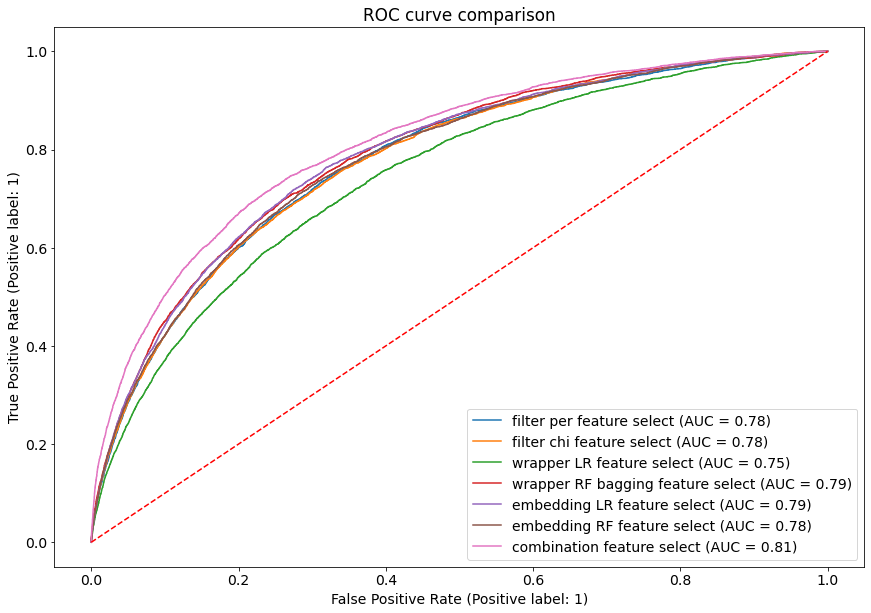

In [24]:
fig, ax = plt.subplots()
per_disp = plot_roc_curve(gbm_per, X_test_per, y_test_per, ax= ax, name = "filter per feature select")
chi_disp = plot_roc_curve(gbm_chi, X_test_chi, y_test_chi, ax= ax, name = "filter chi feature select")
LR_disp = plot_roc_curve(gbm_LR, X_test_LR, y_test_LR, ax= ax, name = "wrapper LR feature select")
RF_disp = plot_roc_curve(gbm_RF, X_test_RF, y_test_RF, ax= ax, name = "wrapper RF bagging feature select")
embedLR_disp = plot_roc_curve(gbm_embedLR, X_test_embedLR, y_test_embedLR, ax= ax, name = "embedding LR feature select")
embedRF_disp = plot_roc_curve(gbm_embedRF, X_test_embedRF, y_test_embedRF, ax= ax, name = "embedding RF feature select")
bagging_disp = plot_roc_curve(gbm_bagging, X_test_bagging, y_test_bagging, ax= ax, name = "combination feature select")
ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust(right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
ax.set_title("ROC curve comparison")
plt.show()

In [26]:
import joblib
joblib.dump(gbm_per, 'C:/data/model/gbm_per.pkl')
joblib.dump(gbm_chi, 'C:/data/model/gbm_chi.pkl')
joblib.dump(gbm_LR, 'C:/data/model/gbm_LR.pkl')
joblib.dump(gbm_RF, 'C:/data/model/gbm_RF.pkl')
joblib.dump(gbm_embedLR, 'C:/data/model/gbm_embedLR.pkl')
joblib.dump(gbm_embedRF, 'C:/data/model/gbm_embedRF.pkl')
joblib.dump(gbm_bagging, 'C:/data/model/gbm_bagging.pkl')
# gbm = joblib.load('C:/data/model/gbm_per.pkl')

['C:/data/model/gbm_bagging.pkl']

In [27]:
X_test_chi.tofile("C:/data/model/X_test.bin")
y_test_chi.tofile("C:/data/model/y_test.bin")

# 对比实验

In [92]:
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [93]:
def model_process(X_train, y_train,X_test,y_test):
    
    # LR
    LR = LogisticRegression(random_state=42, solver='sag',n_jobs=-1)
#     model=LogisticRegression(random_state=0,
#                            solver="sag",
#                            penalty="l2",
#                            class_weight="balanced",
#                            C=1.0,
#                            max_iter=500)
    
    # GaussianNB
    gnb = GaussianNB()
    
    # KNeighbors
    knc = KNeighborsClassifier(n_neighbors=5)
    
    # DNN
    dnn = MLPClassifier(hidden_layer_sizes=(400,),activation='relu',max_iter=300, alpha=0.01,learning_rate_init = 0.01, learning_rate= 'constant')
    
    # 决策树
    clf=DecisionTreeClassifier(random_state=0)
    
    # 随机森林
    rfc=RandomForestClassifier(n_estimators=100)
      
    # 集成学习 adaBoost
    ada = AdaBoostClassifier(n_estimators=100, random_state=0)
    
    # gbm
    gbm = lgb.LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=47,
            max_depth=8,
            learning_rate=0.072283,
            n_estimators= 750,
            objective='binary',
            class_weight=None,
            min_split_gain=0.0222415,
            min_child_weight=60,
            min_child_samples=485,
            subsample=0.6195545,
            subsample_freq=1,
            colsample_bytree=0.60017128,
            reg_alpha=0.5969339,
            reg_lambda=0.7364944,
            random_state=42,
            n_jobs=-1
            
        )
    
    # LR
    print("=============================逻辑回归================================")
    print("训练开始")
    LR = LR.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = LR.predict(X_test)

    print("训练集精确度:{%.3f}    "%LR.score(X_train, y_train), "测试集精确度:{%.3f}    \n"%LR.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, LR.predict_proba(X_train)[:,1]), 
          "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, LR.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,LR.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("LR 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    
    # GaussianNB
    print("=============================GaussianNB================================")
    print("训练开始")
    gnb = gnb.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = gnb.predict(X_test)

    print("训练集精确度:{%.3f}    "%gnb.score(X_train, y_train), 
        "测试集精确度:{%.3f}    \n"%gnb.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, gnb.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, gnb.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,gnb.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("GaussianNB 的KS:{%.4f}"%ks)
    print("=================================================================")
    

     # DNN
    print("=============================DNN================================")
    print("训练开始")
    dnn = dnn.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = dnn.predict(X_test)

    print("训练集精确度:{%.4f}    "%dnn.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%dnn.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, dnn.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, dnn.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    
    fpr,tpr,thresholds = roc_curve(y_test,dnn.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("dnn 的KS:{%.4f}"%ks)
    print("=================================================================")
    
     # Decision Tree
    print("=============================Decision Tree================================")
    print("训练开始")
    clf = clf.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = clf.predict(X_test)

    print("训练集精确度:{%.4f}    "%clf.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%clf.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("dt 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    
     # Random Forest
    print("=============================Random Forest================================")
    print("训练开始")
    rfc = rfc.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = rfc.predict(X_test)

    print("训练集精确度:{%.4f}    "%rfc.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%rfc.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, rfc.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,rfc.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("rf 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    
    # AdaBoost
    print("=============================AdaBoost================================")
    print("训练开始")
    ada = ada.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = ada.predict(X_test)

    print("训练集精确度:{%.4f}    "%ada.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%ada.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, ada.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, ada.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,ada.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("ada 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    
    # gbm
    print("=============================GBM================================")
    print("训练开始")
    gbm = gbm.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = gbm.predict(X_test)

    print("训练集精确度:{%.4f}    "%gbm.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%gbm.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, gbm.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,gbm.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("gbm 的KS:{%.4f}"%ks)
    print("=================================================================")
    

    return LR,gnb,dnn,clf,rfc,ada,gbm

In [94]:
LR,gnb,dnn,clf,rfc,ada,gbm = model_process(X_train_bagging, y_train_bagging, X_test_bagging, y_test_bagging)

=============================逻辑回归================================
训练开始
训练结束
训练集精确度:{0.919}     测试集精确度:{0.919}    

predict_proba 训练集auc:{0.496}  训练集auc:{0.501}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56505
           1       0.00      0.00      0.00      4997

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.84      0.92      0.88     61502

LR 的KS:{0.0393}
=============================GaussianNB================================
训练开始
训练结束
训练集精确度:{0.902}     测试集精确度:{0.901}    

predict_proba 训练集auc:{0.574}  训练集auc:{0.578}

classification_report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     56505
           1       0.13      0.04      0.06      4997

    accuracy                           0.90     61502
   macro avg       0.53      0.51      0.50     61502
weighted av

In [99]:
X_test = X_test_bagging
y_test = y_test_bagging

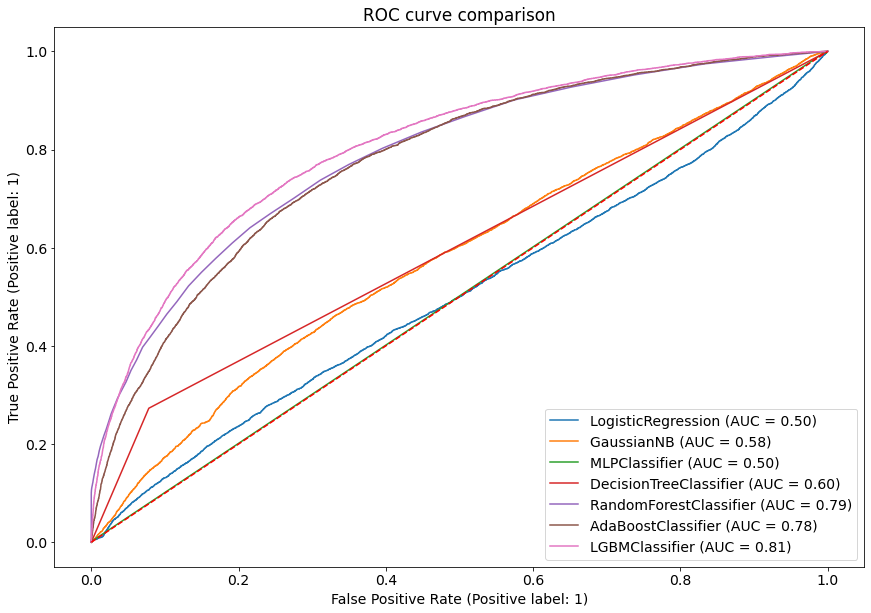

In [102]:
fig, ax = plt.subplots()
disp1 = plot_roc_curve(LR, X_test, y_test, ax= ax)
disp2 = plot_roc_curve(gnb, X_test, y_test, ax= ax)
# disp3 = plot_roc_curve(knc, X_test, y_test, ax= ax)
disp4 = plot_roc_curve(dnn, X_test, y_test, ax= ax)
disp5 = plot_roc_curve(clf, X_test, y_test,ax= ax)
disp7 = plot_roc_curve(rfc, X_test, y_test,ax = ax)
disp8 = plot_roc_curve(ada, X_test, y_test, ax= ax)
disp8 = plot_roc_curve(gbm, X_test, y_test, ax = ax)
ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust(right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
ax.set_title("ROC curve comparison")
plt.show()

# 综合采样

In [179]:
import numpy as np

In [180]:
import imblearn
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
smt.fit(X_train_bagging, y_train_bagging)

SMOTETomek(random_state=42)

In [181]:
X_train_resample, y_train_resample = smt.fit_resample(X_train_bagging, y_train_bagging)

In [182]:
def model_lightgbm(X_train, y_train, X_test, y_test):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(X_train.shape, X_test.shape))           
    
    gbm = lgb.LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=47,
            max_depth=8,
            learning_rate=0.072283,
            n_estimators= 750,
            objective='binary',
            class_weight=None,
            min_split_gain=0.0222415,
            min_child_weight=60,
            min_child_samples=485,
            subsample=0.6195545,
            subsample_freq=1,
            colsample_bytree=0.60017128,
            reg_alpha=0.5969339,
            reg_lambda=0.7364944,
            random_state=42,
            n_jobs=-1
            
        )
        
    gbm.fit(X_train,y_train)
    gbm_y_pre_train = gbm.predict(X_train)
    gbm_y_pre= gbm.predict(X_test)
    gbm_y_proba_train = gbm.predict_proba(X_train)
    gbm_y_proba= gbm.predict_proba(X_test)
    fpr,tpr,thresholds = roc_curve(y_test,gbm_y_proba[:,1])
    ks = max(tpr-fpr)
    
    print("==============================train==================================")
    gbm_accuracy_score_train = accuracy_score(y_train,gbm_y_pre_train)
    gbm_preci_score_train = precision_score(y_train,gbm_y_pre_train)
    gbm_recall_score_train = recall_score(y_train,gbm_y_pre_train)
    gbm_f1_score_train = f1_score(y_train,gbm_y_pre_train)
    gbm_auc_train = roc_auc_score(y_train,gbm_y_proba_train[:,1])
    
    print('gbm_accuracy_score: %f,\ngbm_preci_score: %f,\ngbm_recall_score: %f,\ngbm_f1_score: %f,\ngbm_auc: %f'
          %(gbm_accuracy_score_train,
            gbm_preci_score_train,
            gbm_recall_score_train,
            gbm_f1_score_train,gbm_auc_train))
    
    print("---------------------------------test---------------------------------")
    gbm_accuracy_score=accuracy_score(y_test,gbm_y_pre)
    gbm_preci_score=precision_score(y_test,gbm_y_pre)
    gbm_recall_score=recall_score(y_test,gbm_y_pre)
    gbm_f1_score=f1_score(y_test,gbm_y_pre)
    gbm_auc=roc_auc_score(y_test,gbm_y_proba[:,1])
    print('gbm_accuracy_score: %f,\ngbm_preci_score: %f,\ngbm_recall_score: %f,\ngbm_f1_score: %f,\ngbm_auc: %f,\ngbm_ks:%f'
          %(gbm_accuracy_score,
            gbm_preci_score,
            gbm_recall_score,
            gbm_f1_score,
            gbm_auc,
            ks))

    print("======================================================================")
    return gbm

In [183]:
gbm_bagging_resample =  model_lightgbm(X_train_resample, y_train_resample, X_test_bagging, y_test_bagging)  # 将目标分离出来了，导致少了一维

Starting LightGBM. Train shape: (445958, 139), test shape: (61502, 139)
==============================train==================================
gbm_accuracy_score: 0.968948,
gbm_preci_score: 0.998708,
gbm_recall_score: 0.939111,
gbm_f1_score: 0.967993,
gbm_auc: 0.996816
---------------------------------test---------------------------------
gbm_accuracy_score: 0.932181,
gbm_preci_score: 0.796695,
gbm_recall_score: 0.221933,
gbm_f1_score: 0.347159,
gbm_auc: 0.866664,
gbm_ks:0.577675


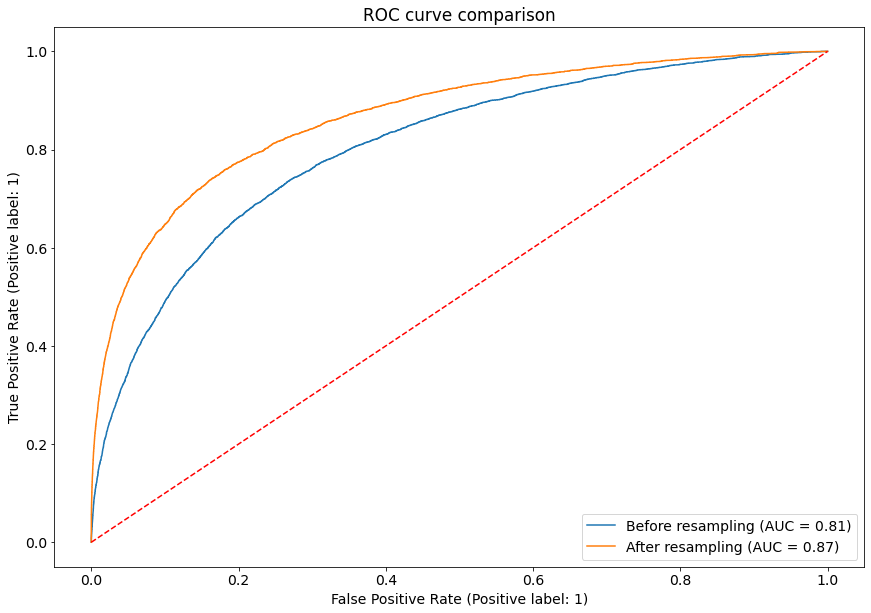

In [184]:
fig, ax = plt.subplots()
disp1 = plot_roc_curve(gbm, X_test_bagging, y_test_bagging, ax= ax, name = "Before resampling")
disp2 = plot_roc_curve(gbm_bagging_resample2, X_test_bagging, y_test_bagging, ax= ax, name = "After resampling")
ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust(right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
ax.set_title("ROC curve comparison")
plt.show()

In [103]:
import imblearn
from imblearn.combine import SMOTETomek

In [108]:
X = select_bagging.drop(["TARGET"], axis = 1)
y = select_bagging["TARGET"].values

In [109]:
columns = X.columns.tolist()

In [105]:
smt = SMOTETomek(random_state=42)
smt.fit(X, y)

SMOTETomek(random_state=42)

In [106]:
X, y = smt.fit_resample(X, y)

In [110]:
data = pd.DataFrame(X, columns=columns)

In [118]:
y = pd.DataFrame(y, columns = ["TARGET"])

In [119]:
data = pd.concat([X,y],axis = 1)
data.shape

(557534, 140)

In [120]:
data.to_csv("C:/data/processing_data/resample_all_data.csv")

In [126]:
train, test = split_train(data, 0.2)
X_train = train.drop(["TARGET"], axis = 1)
y_train = train["TARGET"].values
X_test = test.drop(["TARGET"], axis = 1)
y_test = test["TARGET"].values    

In [127]:
def model_lightgbm(X_train, y_train, X_test, y_test):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(X_train.shape, X_test.shape))
    
    oof_preds = np.zeros(X_train.shape[0])
    sub_preds = np.zeros(X_test.shape[0])
    feats = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    
    X_train = X_train[feats].to_numpy()
    X_test = X_test[feats].to_numpy()                   
    
    gbm = lgb.LGBMClassifier(
            boosting_type='gbdt',
            num_leaves=47,
            max_depth=8,
            learning_rate=0.072283,
            n_estimators= 750,
            objective='binary',
            class_weight=None,
            min_split_gain=0.0222415,
            min_child_weight=60,
            min_child_samples=485,
            subsample=0.6195545,
            subsample_freq=1,
            colsample_bytree=0.60017128,
            reg_alpha=0.5969339,
            reg_lambda=0.7364944,
            random_state=42,
            n_jobs=-1
            
        )
        
    gbm.fit(X_train,y_train)
    gbm_y_pre_train = gbm.predict(X_train)
    gbm_y_pre= gbm.predict(X_test)
    gbm_y_proba_train = gbm.predict_proba(X_train)
    gbm_y_proba= gbm.predict_proba(X_test)
    fpr,tpr,thresholds = roc_curve(y_test,gbm_y_proba[:,1])
    ks = max(tpr-fpr)
    
    print("==============================train==================================")
    gbm_accuracy_score_train = accuracy_score(y_train,gbm_y_pre_train)
    gbm_preci_score_train = precision_score(y_train,gbm_y_pre_train)
    gbm_recall_score_train = recall_score(y_train,gbm_y_pre_train)
    gbm_f1_score_train = f1_score(y_train,gbm_y_pre_train)
    gbm_auc_train = roc_auc_score(y_train,gbm_y_proba_train[:,1])
    
    print('gbm_accuracy_score: %f,\ngbm_preci_score: %f,\ngbm_recall_score: %f,\ngbm_f1_score: %f,\ngbm_auc: %f'
          %(gbm_accuracy_score_train,
            gbm_preci_score_train,
            gbm_recall_score_train,
            gbm_f1_score_train,gbm_auc_train))
    
    print("---------------------------------test---------------------------------")
    gbm_accuracy_score=accuracy_score(y_test,gbm_y_pre)
    gbm_preci_score=precision_score(y_test,gbm_y_pre)
    gbm_recall_score=recall_score(y_test,gbm_y_pre)
    gbm_f1_score=f1_score(y_test,gbm_y_pre)
    gbm_auc=roc_auc_score(y_test,gbm_y_proba[:,1])
    print('gbm_accuracy_score: %f,\ngbm_preci_score: %f,\ngbm_recall_score: %f,\ngbm_f1_score: %f,\ngbm_auc: %f,\ngbm_ks:%f'
          %(gbm_accuracy_score,
            gbm_preci_score,
            gbm_recall_score,
            gbm_f1_score,
            gbm_auc,
            ks))

    print("======================================================================")
    return gbm

In [128]:
gbm_resample = model_lightgbm(X_train, y_train, X_test, y_test)

Starting LightGBM. Train shape: (446028, 139), test shape: (111506, 139)
==============================train==================================
gbm_accuracy_score: 0.968092,
gbm_preci_score: 0.998716,
gbm_recall_score: 0.937433,
gbm_f1_score: 0.967105,
gbm_auc: 0.996765
---------------------------------test---------------------------------
gbm_accuracy_score: 0.955949,
gbm_preci_score: 0.991505,
gbm_recall_score: 0.919528,
gbm_f1_score: 0.954161,
gbm_auc: 0.981393,
gbm_ks:0.912607


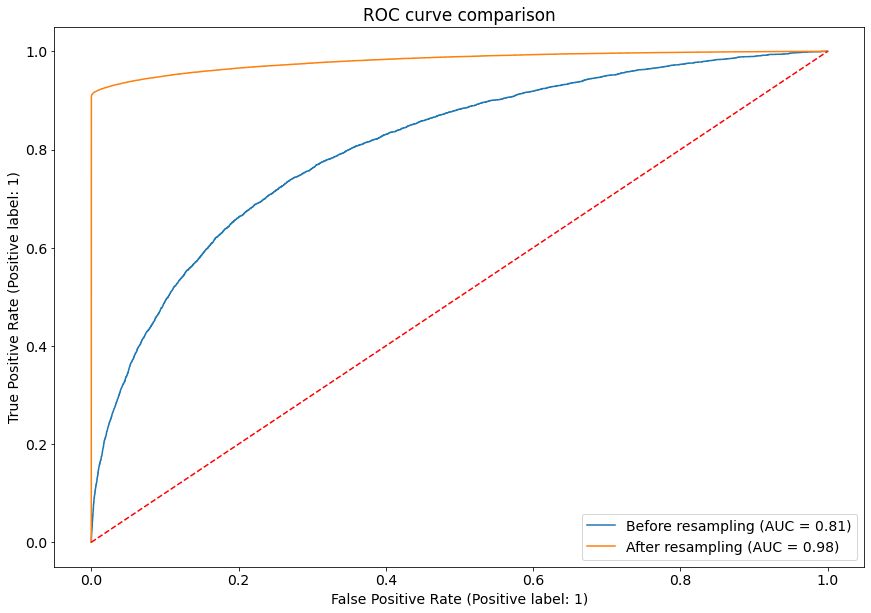

In [129]:
fig, ax = plt.subplots()
disp1 = plot_roc_curve(gbm, X_test_bagging, y_test_bagging, ax= ax, name = "Before resampling")
disp2 = plot_roc_curve(gbm_resample, X_test, y_test, ax= ax, name = "After resampling")
ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust(right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
ax.set_title("ROC curve comparison")
plt.show()